In [1]:
# Steps required
# Create a data pipeline that reads in image from file directory and is able to pass the image to model for training

# Design of U-Net backbone

# Design of CBAM attention model

# Design of U-Net integrated with CBAM and the skip connections

# Design of loss functions

# Design of visualisation to evaluate model
    # 1. Generate ground truth after a certain number of epochs
    # 2. Training curves
    # 3. Grad-CAM mask (mentioned in CBAM paper)

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

from cbam_unet import *
sys.path.append(os.path.join(os.getcwd(), '..', 'helpers'))
from visualisation_helpers import *

%load_ext autoreload
%autoreload 2

In [3]:
print(tf.version.VERSION)

2.15.0


# 0. Read in images and preprocess them
Source: https://www.tensorflow.org/tutorials/load_data/images

- Step 1: Specify batch size and image dimensions (Specifying the dimension results in Tensorflow cropping the image for you)
- Step 2: Split the dataset into train and validation split
- Step 3: Normalise the pixel values

In [4]:
# Step 1

train_batch_size = 8 # change back to 8 later
val_batch_size = 3 # change back to 10 later
img_height = 400
img_width = 400
num_channels = 3

In [5]:
# Step 2
# Use a seed of 1 to ensure reproducibility of results
# Use ImageDataGenerator instead

seed = 1
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

# Equivalent to x_train
train_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="training",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to x_val
val_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

# Equivalent to y_train
train_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to y_val
val_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.
Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.


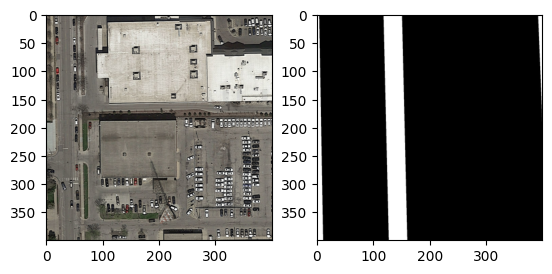

In [7]:
_imgs = []
_gts = []

for images in train_imgs_ds.take(1):
    for i in range(1):
        _imgs.append(images[i].numpy().astype("uint8"))

for gts in train_gts_ds.take(1):
    for i in range(1):
        _gts.append(gts[i].numpy().astype("uint8"))

fig, axs = plt.subplots(1,2)
#fig, axs = plt.subplots(2,2, figsize=(6, 8))

axs[0].imshow(_imgs[0])
axs[1].imshow(_gts[0], cmap="gray")
                   
#axs[1][0].imshow(_imgs[1])
#axs[1][1].imshow(_gts[1], cmap="gray")

In [8]:
# Step 3
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_imgs_ds = train_imgs_ds.map(lambda x: (normalization_layer(x)))
val_imgs_ds = val_imgs_ds.map(lambda x: (normalization_layer(x)))

train_gts_ds = train_gts_ds.map(lambda x: (normalization_layer(x)))
val_gts_ds = val_gts_ds.map(lambda x: (normalization_layer(x)))

In [9]:
sample_img_batch = next(iter(train_imgs_ds))
sample_image = sample_img_batch[0]

sample_gt_batch = next(iter(train_gts_ds))
sample_gt = sample_gt_batch[0]

print(f'Sample image, min. pixel value: {np.min(sample_image)}, max. pixel value: {np.max(sample_image)}')
print(f'Sample gt, min. pixel value: {np.min(sample_gt)}, max. pixel value: {np.max(sample_gt)}')

Sample image, min. pixel value: 0.0, max. pixel value: 1.0
Sample gt, min. pixel value: 0.0, max. pixel value: 0.9294118285179138


# 1. Instantiate model and train model

In [9]:
# Show summary of the model
input_shape = (None, img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape)
cbam_unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
cbam_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 encoder__conv_block (Encod  (None, 400, 400, 64)         38720     ['input_1[0][0]']             
 er_ConvBlock)                                                                                    
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 200, 200, 64)         0         ['encoder__conv_block[0][0]'] 
 D)                                                                                               
                                                                                              

In [10]:
# print(cbam_unet_model.trainable_weights)

In [10]:
# Write training loop for model

# Hyperparameters
num_epochs = 5 # 100
generate_every = 2 # 10
lr = 0.00001

# Arrays to store results
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

# Convert datasets into an list for easy iteration
train_imgs = list(iter(train_imgs_ds))
train_gts = list(iter(train_gts_ds))
val_imgs = list(iter(val_imgs_ds))
val_gts = list(iter(val_gts_ds))

# Instantiate model
input_shape = (None, img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape)

# Define optimiser
optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
cbam_unet_model.compile(optimizer = optimiser)

# Start training loop
for epoch in range(num_epochs):
    
    print(f'Start of epoch {epoch}.')
    for batch_no, train_imgs_batch in enumerate(train_imgs):
        
        print(train_imgs[batch_no][0])
        
        with tf.GradientTape() as tape:
                    
            # Pass images into model and get prediction
            train_outputs = cbam_unet_model(train_imgs[batch_no])
                          
            # Calculate loss
            train_loss = cbam_unet_model.compute_loss(train_gts[batch_no], train_outputs)
    
        # Compute and apply gradients
        grads = tape.gradient(train_loss, cbam_unet_model.trainable_weights)
        optimiser.apply_gradients(zip(grads, cbam_unet_model.trainable_weights))

    # Calculate on validation set
    val_outputs = cbam_unet_model(val_imgs[0]) # only one batch for validation
    val_loss = cbam_unet_model.compute_loss(val_gts[0], val_outputs)

    # Compute metrics
    train_acc, train_iou, train_dice = cbam_unet_model.compute_metrics(train_gts[batch_no], train_outputs)
    val_acc, val_iou, val_dice = cbam_unet_model.compute_metrics(val_gts[0], val_outputs)
        
    # Save results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    
    print(f'tr_Loss: {train_loss}, tr_acc: {train_acc}, tr_iou: {train_iou}, tr_dice: {train_dice}')
    print(f'val_Loss: {val_loss}, val_acc: {val_acc}, val_iou: {val_iou}, val_dice: {val_dice}')
    
    # Generate the segmentation map and save it every 'generate_every' epochs
    if epoch % generate_every == 0 and epoch > 0:
        plt.imsave(f'train_epoch_{epoch}.png', train_outputs[0], cmap='gray')

Start of epoch 0.
tf.Tensor(
[[[0.63529414 0.627451   0.58431375]
  [0.30980393 0.30980393 0.3019608 ]
  [0.0627451  0.07058824 0.08235294]
  ...
  [0.35686275 0.33333334 0.3137255 ]
  [0.3647059  0.34901962 0.32941177]
  [0.3647059  0.36078432 0.3372549 ]]

 [[0.5803922  0.5647059  0.5176471 ]
  [0.40000004 0.38823533 0.36862746]
  [0.16078432 0.16078432 0.17254902]
  ...
  [0.35686275 0.33333334 0.3137255 ]
  [0.3647059  0.34901962 0.33333334]
  [0.36862746 0.36078432 0.34509805]]

 [[0.21568629 0.20784315 0.21176472]
  [0.227451   0.23529413 0.22352943]
  [0.27058825 0.2901961  0.25490198]
  ...
  [0.34901962 0.33333334 0.30980393]
  [0.35686275 0.34117648 0.32156864]
  [0.36862746 0.36078432 0.34117648]]

 ...

 [[0.16862746 0.16078432 0.16470589]
  [0.14509805 0.14117648 0.13725491]
  [0.14117648 0.12156864 0.14901961]
  ...
  [0.45098042 0.42352945 0.40784317]
  [0.4666667  0.43921572 0.41960788]
  [0.4666667  0.44705886 0.42352945]]

 [[0.14117648 0.13333334 0.13725491]
  [0.200

KeyboardInterrupt: 

# Extra: Testing

In [ ]:
sample_img = train_imgs_ds.take(1)
sample_gt = train_gt_ds.take(1)

In [ ]:
sample_output = None

for img in sample_img:
    sample_output = cbam_unet_model(img)

In [ ]:
sample_gt_ = None

for gt in sample_gt:
    sample_gt_ = gt

In [ ]:
# Visualise predicted segmentation map and ground truth 
concatenate_seg_maps(sample_gt_.numpy()[0], sample_output.numpy()[0])

In [ ]:
sample_img_ = None

for img in sample_img:
    sample_img_ = img

In [ ]:
colour_mask = segmap_to_colourmask(400, 400, sample_output.numpy()[0])
overlayed_img = make_img_overlay(sample_img_.numpy()[0], colour_mask)
plt.imshow(overlayed_img)